# Physics 113: Problem Set 2

## Submit notebook to Canvas by Tuesday, May 14, 2024 11:59pm PDT

## Question 1: Constraining the Neutron Star Equation of State (10 points)

We've recently discussed how to integrate ODEs using the 4th Order Runge-Kutta
Method in class. In this question we are going to couple this with the interpolation
to model the effect of binary neutron stars during the early stages of a merger!

The neutron star equation of state (EOS) is a fundamental problem in astrophysics that has important implications for our understanding of the nature of matter under extreme conditions, as well as for the dynamics of compact astrophysical objects such as neutron stars and black holes. Neutron stars are some of the densest objects in the universe, with core densities that can reach several times that of nuclear saturation density. Understanding the EOS for neutron stars provides insight into the behavior of matter at these extreme densities, which cannot be directly probed in terrestrial laboratories.

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from pathlib import Path
from tqdm.auto import tqdm
from typing import Dict, List, Optional
from dataclasses import dataclass, field, InitVar
from astropy import units as u
from astropy import constants as const
from scipy.integrate import solve_ivp
from scipy.special import factorial2, lpmn, lqmn

/Users/devg/Downloads/physics113/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1A: Set Up the Neutron Star Equation of State (2 points)

The EoS describes the relationship between the pressure, density, and temperature of the matter inside a neutron star. Constraining the EOS is crucial because it impacts a variety of observables related to neutron stars, such as their mass, radius, and tidal deformability. These quantities can provide valuable information on the composition, structure, and properties of neutron stars, as well as the fundamental forces and particles governing their behavior.

For simplicity, we're just going to focus on the density $\epsilon$ and pressure
$P$, making our EoS model the following form $P(\epsilon)$.

<font color='darkorange'>WARNING!! 

Before running the any of the computation below it is very import that we normalize or units or else
we'll run into a slew of problems! A good relativist tries to work with units
where $G=c=1$ because it allows the units of each value to be related to some exponential
scaling of length (i.e., $L^n$ where $n \in \mathbb Z$).

The datasets used in this assignment have already been preprocessed to have units of $\frac{{\rm g}}{{\rm cm}^3}$, so please take that into consideration.

There are some hints throughout the notebook to help get you started.

In [2]:
eos_factor = (const.G / (const.c**2)).cgs

Let's create our EoS Model! Much of the model code is already written, and this will give you practice 
reading and understanding someone else's code (a commonly needed skill in collaborative physics research!)

In the equation of state model below please fill out the empty methods `get_pressure` and `get_speed_of_sound` with an
interpolation scheme to produce the correct pressure $P$, density $\epsilon$, and
squared sound speed $c_{s}^{2}$. Where

> $$c_{s} = \sqrt{\frac{dP}{d\epsilon}}$$

Note that there is a class attribute that stores $\log_{10}P$ and $\log_{10}\epsilon$
values in the case you need to use them. For example, we can interpolate density given pressure by calling
```python
10.0 ** np.interp(np.log10(pressure), self.log_pressures, self.log_densities)
```

In [3]:
@dataclass
class EquationOfState:
    name: str
    pressures: np.ndarray
    densities: np.ndarray
    speed_of_sounds: np.ndarray = field(init=False)

    central_densities: list = field(init=False)
    central_pressures: list = field(init=False)
    central_cutoff: float = field(default=11.0)

    factor: InitVar[Optional[float]] = field(default=None)

    def __post_init__(self, factor: Optional[float] = None) -> None:
        central_mask = np.log10(self.pressures) >= self.central_cutoff

        if factor is not None:
            convert = lambda x: (factor * x * u.g / u.cm**3).to_value("km**-2")
            self.densities = convert(self.densities)
            self.pressures = convert(self.pressures)
        self.speed_of_sounds = np.gradient(self.pressures, self.densities)

        self.central_densities = list(self.densities[central_mask])
        self.central_pressures = list(self.pressures[central_mask])

        self.log_densities = np.log10(self.densities)
        self.log_pressures = np.log10(self.pressures)

    def __repr__(self) -> str:
        return f"{self.name} Equation of State"

    @classmethod
    def from_data_files(cls, path: Path, factor: Optional[float]=None) -> dict:
        eos_data = pickle.load(open(path.as_posix(), 'rb'))
        return {
            key : cls(key, eos[:, 0], eos[:, 1], factor=factor)
            for key, eos in eos_data.items()
        }

    def get_density(self, pressure: float) -> float:
        return 10.0 ** np.interp(
            np.log10(pressure), self.log_pressures, self.log_densities
        )

    def get_pressure(self, density: float) -> float:
        ## your code goes here ✅
        return 10.0 ** np.interp(np.log10(density), self.log_densities, self.log_pressures)

    def get_speed_of_sound(self, pressure: float) -> float:
        ## your code goes here ✅
        return np.sqrt(pressure/self.get_density(pressure))

    def plot(self, ax: Optional[plt.Axes]=None) -> None:
        inverse_factor = ((const.c**2) / const.G).cgs
        convert = lambda x: ((x /u.km**2).cgs * inverse_factor)
        densities, pressures = convert(self.densities), convert(self.pressures)

        if ax is not None:
            ax.loglog(densities, pressures, label=self.name)
        else:
            _, ax = plt.subplots(figsize=(8, 6))
            ax.loglog(densities, pressures)
            ax.set_xlabel(r"Density $\log_{10}\rho$, $[g/cm^{-3}]$", fontsize=14)
            ax.set_ylabel(r"Pressure, $\log_{10}P$, $[g/cm^{-3}]$", fontsize=14)
            ax.set_title(self.__repr__(), fontsize=16)
            plt.show()

### 1B: Loading Neutron Star EOS Data (2 points)

In [4]:
# Load equation of state
data_path = Path(Path.cwd(), 'data/eos_data.pkl')
eos_data = EquationOfState.from_data_files(data_path, factor=eos_factor)
print(f"We have {len(eos_data)} different equation of states in total.")

We have 41 different equation of states in total.


We have 41 different equation of states in total, but we'll focus on one to start, feel free to experiment with the others

In [5]:
target_datasets = ["gs1"]

Let's plot them to see what they look like!

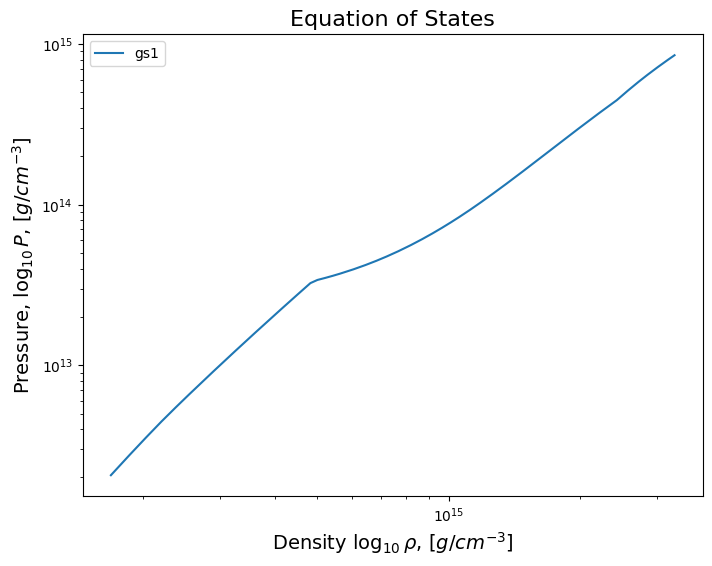

In [6]:
def plot_equation_of_states(data: dict, datasets: Optional[List[str]]) -> None:
    _, ax = plt.subplots(figsize=(8, 6))

    for dataset in datasets:
        eos = data[dataset]
        eos.plot(ax)

    ax.set_xlabel(r"Density $\log_{10}\rho$, $[g/cm^{-3}]$", fontsize=14)
    ax.set_ylabel(r"Pressure, $\log_{10}P$, $[g/cm^{-3}]$", fontsize=14)
    ax.set_title("Equation of States", fontsize=16)
    ax.legend()
    plt.show()

plot_equation_of_states(eos_data, target_datasets)

Describe your interpretation of the plot in your own words. What area of this plot corresponds to the
interior vs the exterior regions of the star? ✅

✍🏽 Here, we're plotting the log pressure against the log density equation of states. While the axis are log axis, we can generally recognize that there is a distinct change in the graph at around (4e14, 2e13). We can assume that this is where the exterior region of the star ends and we enter the interior regions of the star because this is the most dense and high pressure. Hence the exterior of the star is on the left and the interior is on the right side of the graph. This is because we expect the highest pressures and densities to be located on the center or interior of the star.

### 1C: Constraining Neutron Star EOS (2 points)

One way to constrain the neutron star EoS is through the measurement of their mass $M$ and radius $R$. Observations of binary neutron star systems or neutron stars in binary systems with other types of stars can provide estimates of their masses through the analysis of their orbital dynamics. On the other hand, the radius can be estimated through X-ray observations of neutron stars, by modeling their thermal emission and exploiting the relationship between the observed X-ray flux and the surface area of the star. By comparing these observed mass-radius relations with theoretical models, we can place constraints on the EoS and better understand the underlying physics.

Tidal deformability, $\Lambda$ is another important property that can help us constrain the neutron star EoS. Tidal deformability refers to the degree to which a neutron star is deformed under the influence of an external gravitational field, such as that of a companion star in a binary system. This property is closely related to the star's internal structure and can be probed through the observation of gravitational waves emitted during the inspiral and merger of compact binary systems, like those composed of two neutron stars or a neutron star and a black hole. The detection and analysis of gravitational wave signals can provide estimates of the tidal deformability of the neutron stars involved in the merger, which can be compared with theoretical models to further constrain the EoS.

Now we're going to set up our neutron star!

In order to help make computation a bit easier, we need to fill out a couple of
helper functions. In the model below fill out the methods that compute the star's
compactness ✅

> $$\mathcal{C} = \frac{M}{R}$$

the $g_{rr}$ Schwarzschild metric term

> $$g_{rr} = \left[1 - \frac{2M}{R} \right]^{-1}$$

and tidal deformability

> $$\Lambda_{\ell} = \frac{-1}{(2\ell -1)!!}\left. \frac{\hat{P}_{\ell 2}^{\prime}(x)-\mathcal{C}Y_{\ell}\hat{P}_{\ell 2}(x)}{\hat{Q}_{\ell 2}^{\prime}(x)-\mathcal{C}Y_{\ell}\hat{Q}_{\ell 2}(x)} \right|_{x = \mathcal{C}^{-1}-1}$$

where $Y_{\ell}$ is the fully evolved tidal perturbation that will be computed
below and $\hat{P}_{\ell 2}(x),\hat{Q}_{\ell 2}(x)$ are the associated Legendre
polynomials of the first and second kind. Since gravitational waves are produced
by accelerating quadrupole moments, we will set $\ell = 2$.

There are some helper functions that have been imported from scipy to help
compute some of these values (including the double factorial term).

Similar to the EoS model we need to implement a conversion factor in the
`get_mass_radius` function in order to help get correct units for our final
output.

In [7]:
@dataclass
class NeutronStar:
    density: float
    pressure: float
    eos: EquationOfState
    mass: float = field(init=False)
    radius: float = field(default=0.0)

    multipole_order: int = field(default=2)
    tidal_pertubation: float = field(init=False)

    def __post_init__(self) -> None:
        self.mass = 4.0 * np.pi * self.radius**3 * self.density / 3.0
        self.tidal_pertubation = self.multipole_order

    def __repr__(self) -> str:
        mass, radius = self.get_mass_radius
        return f"NeutronStar(mass={mass:.2f} Msun, radius={radius:.2f} km)"


    def evolve(self, properties: np.ndarray, dr: float) : # -> NeutronStar: not working but unnecessary
        pressure = self.pressure + properties[0]
        density = self.eos.get_density(pressure)
        new_radius = self.radius + dr
        new_star = NeutronStar(density, pressure, self.eos, radius=new_radius)
        new_star.mass = self.mass + properties[1]
        new_star.tidal_pertubation = self.tidal_pertubation + properties[2]
        return new_star


    @property
    def compactness(self) -> float:
        ## your code here ✅
        return self.mass / self.radius

    @property
    def grr(self) -> float:
        ## your code here ✅
        return (1 - (2 * self.mass)/(self.radius))**(-1)

    @property
    def speed_of_sound(self) -> float:
        return self.eos.get_speed_of_sound(self.pressure)

    @property
    def tidal_deformability(self) -> float:
        l, C, Y = self.multipole_order, self.compactness, self.tidal_pertubation
        x = (1. / C) - 1
        (Pmn_x, Pmn_d_x), (Qmn_x, Qmn_d_x) = lpmn(l, 2, x), lqmn(l, 2, x)
        Pl2_x, Pl2_d_x = Pmn_x[l, 2], Pmn_d_x[l, 2]
        Ql2_x, Ql2_d_x = Qmn_x[l, 2], Qmn_d_x[l, 2]
        a_l = (Pl2_d_x - C * Y * Pl2_x) / (Ql2_d_x - C * Y * Ql2_x)
        return (-1. / factorial2((2 * l - 1), exact=True)) * a_l

    @property
    def get_mass_radius(self) -> tuple:
        inverse_factor = (const.c**2/ const.G).to("kg/km")
        convert = lambda x: (inverse_factor * x * u.km).to_value("Msun")
        return convert(self.mass), self.radius

### 1D: Setting up System of ODEs (2 points)

Now we need to set up our system of ODEs!

Implement the following equations below

> $$\frac{dP}{dr} = -\frac{\left(\epsilon+p\right)\left(m+4\pi r^{3}p\right)}{r \left(r - 2m \right)}$$
> $$\frac{dm}{dr} = 4\pi r^{2} \epsilon$$
> $$r\frac{dy_{\ell}}{dr} + y_{\ell}\left[y_{\ell}-1\right] + A(r)y_{\ell} - B_{\ell}(r) = 0$$

where

> $$A(r) = 2g_{rr}\left[1-\frac{3m}{r}-2\pi r^{2}(\epsilon+3p)\right]$$
> $$B_{\ell}(r) = g_{rr}\left[\ell(\ell+1)-4\pi r^{2}(\epsilon+3p)(3+c_{s}^{-2})\right]$$

In [8]:
def pressure_diff(ns: NeutronStar) -> float:
    ## your code here ✅
    epsilon = ns.eos.get_density(ns.pressure)
    p = ns.pressure
    m = ns.mass
    r = ns.radius

    dPdr = -((epsilon + p) * (m + 4 * np.pi * r ** 3 * p)) / (r * (r - 2 * m))

    return dPdr

def mass_diff(ns: NeutronStar) -> float:
    ## your code here ✅
    epsilon = ns.eos.get_density(ns.pressure)
    r = ns.radius

    dmdr = 4 * np.pi * r ** 2 * epsilon

    return dmdr

def tidal_diff(ns: NeutronStar) -> float:
     ## your code here ✅
    l = ns.multipole_order
    r = ns.radius
    g_rr = ns.grr
    epsilon = ns.eos.get_density(ns.pressure)
    p = ns.pressure
    cs2 = ns.speed_of_sound ** 2
    
    A = 2 * g_rr * (1 - 3 * ns.mass / r - 2 * np.pi * r ** 2 * (epsilon + 3 * p))
    B_l = g_rr * (l * (l + 1) - 4 * np.pi * r ** 2 * (epsilon + 3 * p) * (3 + 1 / cs2))
    y_l = ns.tidal_pertubation
    
    dyl_dr = (B_l - y_l * (y_l - 1) - A * y_l) / r
    
    return dyl_dr

def evolve_step(radius: float, ns: NeutronStar) -> np.ndarray[float]:
    if (ns.radius == 0.0): return np.zeros(3)
    return np.array([pressure_diff(ns), mass_diff(ns), tidal_diff(ns)])

### 1E: Implement the Runge-Kutta method and Solve the Neutron Star ODEs (2 points)

Almost there !

Implement the 4th-Order Runge-Kutta method in the `stepRK4` method. Please use the
`evolve_step` function to perform proper updates.

In [9]:
class StarSolver:
    def __init__(self, eos: EquationOfState, dr: float = 0.01) -> None:
        self.name = eos.name
        self.dr = dr

        # Initialize the stars
        centrals = zip(eos.central_densities, eos.central_pressures)
        self.stars = [
            NeutronStar(pressure=pressure, density=density, eos=eos)
            for density, pressure in centrals
        ]

        print(f"Initialized {len(self.stars)} stars.")

        # Define Cutoff
        self.cutoff_pressure = max(0, min(eos.pressures))

    def __repr__(self) -> str:
        return f"StarSolver(name={self.name})"

    def solve(self) -> List[NeutronStar]:
        evolved_stars = []
        for ns in tqdm(self.stars, desc="Evolving Neutron Stars"):
            while (ns.pressure > self.cutoff_pressure):
                evolved_ns = self.stepRK4(ns)
                ns = evolved_ns
            evolved_stars.append(ns)
        return evolved_stars

    def stepRK4(self, ns: NeutronStar) -> NeutronStar:
        r, ns_copy = copy(ns.radius), copy(ns)
        # your code here: Implement the RK4 method ✅
        h = self.dr

        k1 = h * evolve_step(r, ns_copy)
        ns_copy = ns.evolve(k1 / 2, h / 2)

        k2 = h * evolve_step(r + h / 2, ns_copy)
        ns_copy = ns.evolve(k2 / 2, h / 2)

        k3 = h * evolve_step(r + h / 2, ns_copy)
        ns_copy = ns.evolve(k3, h)

        k4 = h * evolve_step(r + h, ns_copy)

        k = (k1 + 2 * k2 + 2 * k3 + k4) / 6.0

        return ns.evolve(k, h)


Run the cells below.

In [10]:
solvers = {dataset : StarSolver(eos_data[dataset]) for dataset in target_datasets}
solvers

Initialized 136 stars.


{'gs1': StarSolver(name=gs1)}

In [11]:
# This may take a bit
evolved_stars = {dataset : solver.solve() for dataset, solver in solvers.items()}

Evolving Neutron Stars: 100%|██████████| 136/136 [00:10<00:00, 13.00it/s]


In [12]:
def plot_evolved_stars(evolved_stars: Dict[str, List[NeutronStar]]) -> None:
    ''' Plot Mass-Radii and Tidal Deformability as 1x2 subplots'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    for key, stars in evolved_stars.items():
        # Mass-Radii Plot
        masses, radii = zip(*[star.get_mass_radius for star in stars])
        ax1.plot(radii, masses, "o", label=key)
        ax1.set_xlabel(r"Radius, $R$ $[km]$", fontsize=14)
        ax1.set_ylabel(r"Mass, $M$  $[M_{\odot}]$", fontsize=14)
        ax1.tick_params(axis='both', which='major', labelsize=12)

        # Tidal Deformability Plot
        compactness, deformability = zip(*[
            (star.compactness, star.tidal_deformability) for star in stars
        ])
        ax2.plot(compactness, deformability, "o", label=key)
        ax2.set_xlabel(r"Compactness, $\mathcal{C}$", fontsize=14)
        ax2.set_ylabel(r"Tidal Deformability, $\Lambda$", fontsize=14)
        ax2.tick_params(axis='both', which='major', labelsize=12)
        ax2.set_ylim(0, 1200)  # Set upper limit on the y-axis

    # Position the legend outside of the right subplot
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

    fig.suptitle("Mass-Radius and Tidal Deformabilities", fontsize=18)
    plt.show()

/var/folders/9r/sw7rn4810sjddctl8q8nlcy80000gn/T/ipykernel_47050/935960377.py:34: RuntimeWarning: invalid value encountered in scalar divide
  return self.mass / self.radius


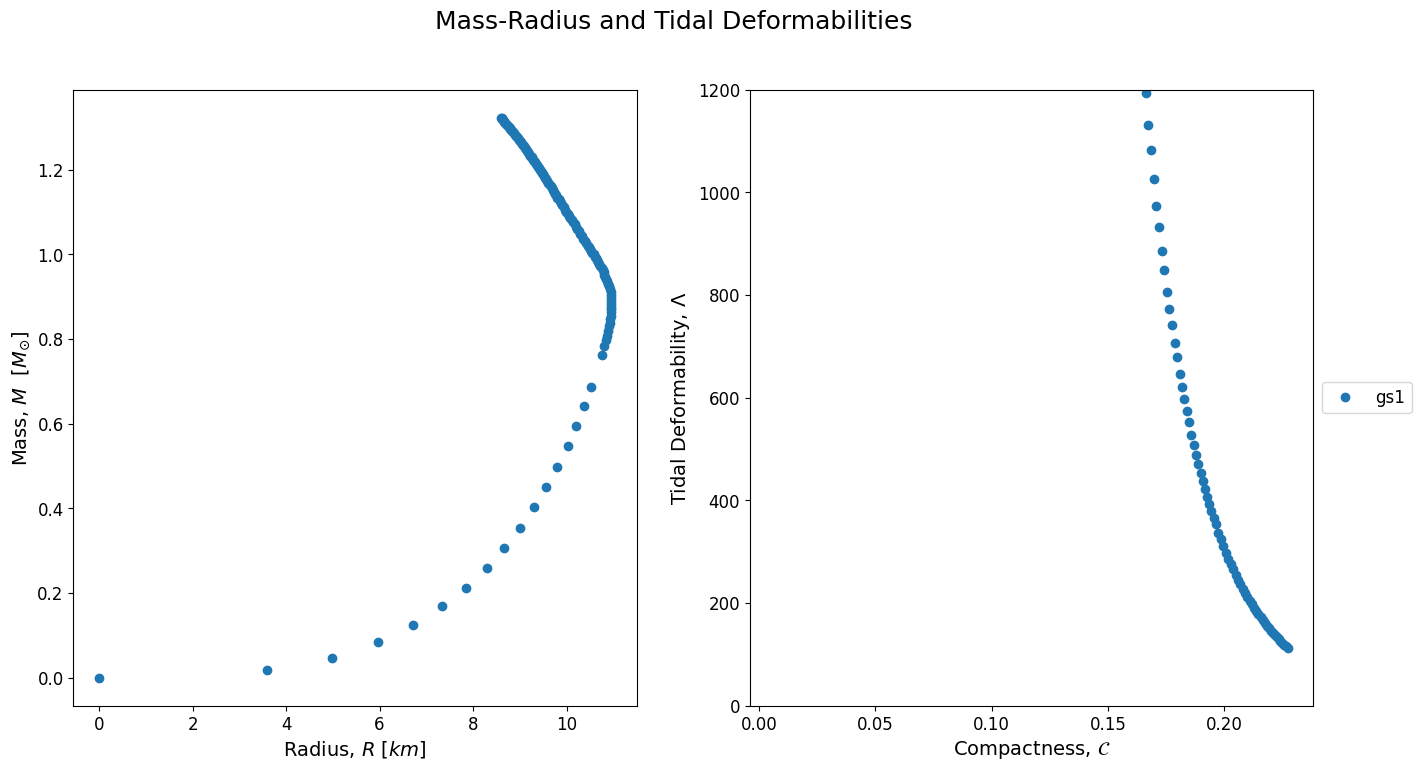

In [13]:
plot_evolved_stars(evolved_stars)

Congrats! You've finished! Feel free to do so some exploring be changing the step
size of the solver or potentially adding additional integration step methods to
`StarSolver` to see how your results and performance may change. ✅

In [14]:
class StarSolver:
    def __init__(self, eos: EquationOfState, dr: float = 0.1) -> None:
        self.name = eos.name
        self.dr = dr

        # Initialize the stars
        centrals = zip(eos.central_densities, eos.central_pressures)
        self.stars = [
            NeutronStar(pressure=pressure, density=density, eos=eos)
            for density, pressure in centrals
        ]

        print(f"Initialized {len(self.stars)} stars.")

        # Define Cutoff
        self.cutoff_pressure = max(0, min(eos.pressures))

    def __repr__(self) -> str:
        return f"StarSolver(name={self.name})"

    def solve(self) -> List[NeutronStar]:
        evolved_stars = []
        for ns in tqdm(self.stars, desc="Evolving Neutron Stars"):
            while (ns.pressure > self.cutoff_pressure):
                evolved_ns = self.stepRK4(ns)
                ns = evolved_ns
            evolved_stars.append(ns)
        return evolved_stars

    def stepRK4(self, ns: NeutronStar) -> NeutronStar:
        r, ns_copy = copy(ns.radius), copy(ns)
        # your code here: Implement the RK4 method ✅
        h = self.dr

        k1 = h * evolve_step(r, ns_copy)
        ns_copy = ns.evolve(k1 / 2, h / 2)

        k2 = h * evolve_step(r + h / 2, ns_copy)
        ns_copy = ns.evolve(k2 / 2, h / 2)

        k3 = h * evolve_step(r + h / 2, ns_copy)
        ns_copy = ns.evolve(k3, h)

        k4 = h * evolve_step(r + h, ns_copy)

        k = (k1 + 2 * k2 + 2 * k3 + k4) / 6.0

        return ns.evolve(k, h)


In [15]:
solvers = {dataset : StarSolver(eos_data[dataset]) for dataset in target_datasets}
solvers

Initialized 136 stars.


{'gs1': StarSolver(name=gs1)}

In [16]:
# This may take a bit
evolved_stars = {dataset : solver.solve() for dataset, solver in solvers.items()}

Evolving Neutron Stars: 100%|██████████| 136/136 [00:01<00:00, 131.78it/s]


/var/folders/9r/sw7rn4810sjddctl8q8nlcy80000gn/T/ipykernel_47050/935960377.py:34: RuntimeWarning: invalid value encountered in scalar divide
  return self.mass / self.radius


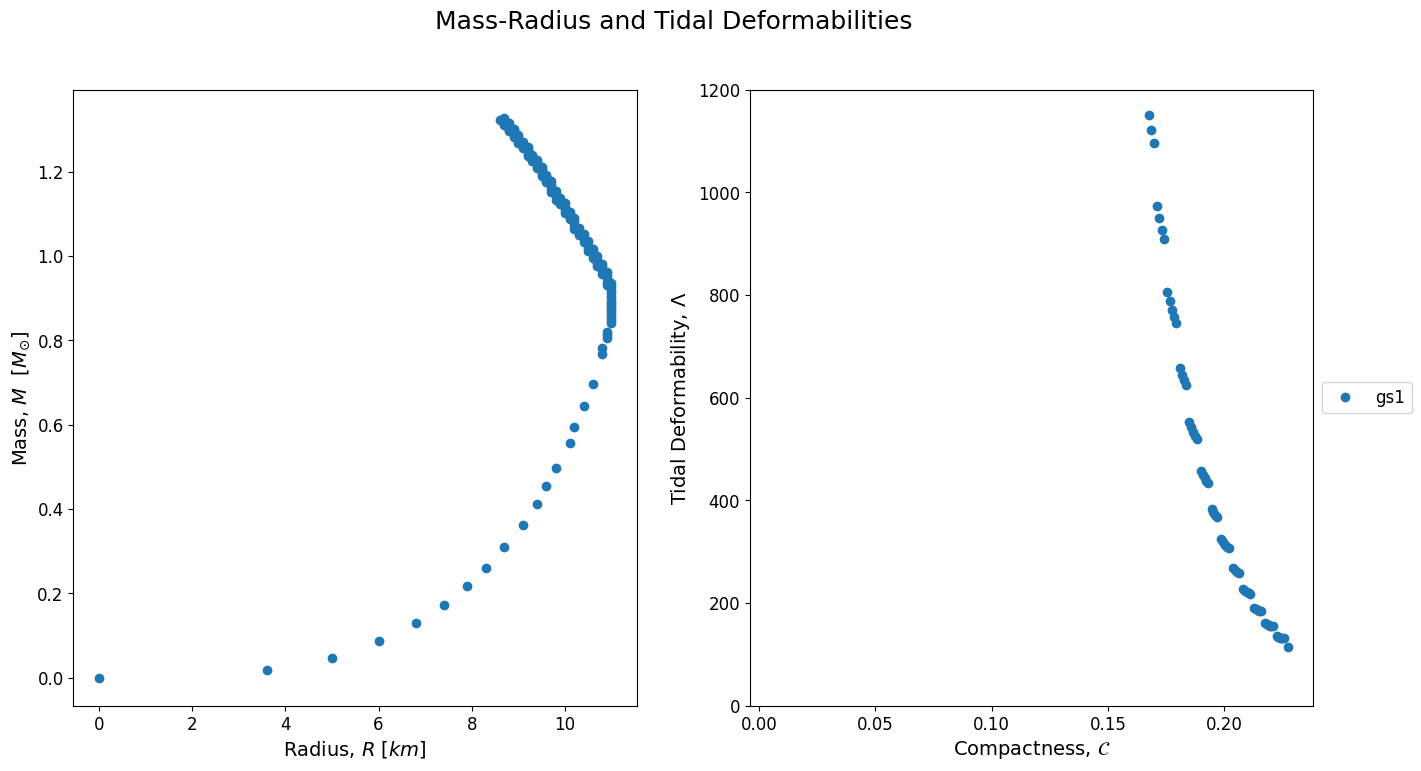

In [17]:
plot_evolved_stars(evolved_stars)

✍🏽 We recognize that when we change the step size from 0.01 to 0.1, the plot becomes much more rigid and less continous. For example, when looking at tidal deformability versus compactness, the datapoints are in rigid clumps as opposed to the more continous solution we had earlier with dr = 0.01. 

## Question 2: Obtaining mathematical constants via ODEs (10 points)


### 2A: $e$, $\ln 2$, and $\pi$ (4 points)
This task describes the numbers $e = 2.7182818\dots$, $\ln 2 = 0.693147\ldots,$ and $\pi = 3.141592\ldots$ as specific values of certain initial value problems.

In each case, apply each of your Euler, RK2, and RK4 methods with $n = 10, 20, 40, \ldots, 81920 = 10 * 2^{13}$ subintervals to solve for:


*   $e = y(1)$, where $y(x)$ is the solution of the initial value problem $\frac{dy}{dx} = y$ with $y(0) = 1$. ✅
*   $\ln 2 = y(2)$, where $y(x)$ is the solution of the initial value problem $\frac{dy}{dx} = 1/x$ with $y(1) = 0$. ✅
*   $\pi = y(1)$, where $y(x)$ is the solution of the initial value problem $\frac{dy}{dx} =  4/(1+x^2)$ with $y(0) = 0$. ✅

In [18]:
# --------------------------------------------------------------------------
# define solvers
"""
Inputs: func, xk, k and deltat.
Outputs: x_k+1. 

Notes: We use k to index time here. Euler = order 1 solver, rk2 = order 2 solver and rk4 = order 4 solver.
"""

def euler_step(func, xk, k, delta_t):
    return xk + func(xk, k)*delta_t

def rk2step(func, xk, k, deltat):
    f1 = func(xk, k)
    f2 = func(xk + 0.5*deltat*f1, k + 0.5*deltat)
    return xk + deltat*f2 

def rk4step(func, xk, k, deltat):
    f1 = func(xk, k)
    f2 = func(xk + 0.5*deltat*f1, k + 0.5*deltat)
    f3 = func(xk + 0.5*deltat*f2, k + 0.5*deltat)
    f4 = func(xk + deltat*f3, k + deltat)
    return xk + (deltat/6)*(f1 + 2*f2 + 2*f3 + f4)

# --------------------------------------------------------------------------
# define diff eqs
"""
Inputs: y, x.
Outputs: dy/dx

"""
def e_dy_dx(y, x):
    return y

def ln_dy_dx(y, x):
    return (1/x)

def pi_dy_dx(y, x):
    return 4/(1 + x**2)

# --------------------------------------------------------------------------
# solve for e
tstart, tend = 0, 1
results_e = np.zeros((3, 14))

for index, n in enumerate([10*2**n for n in range(14)]):
    deltat = (tend - tstart)/n

    # initialize initial values for ivp
    e_euler_est = 1
    e_rk2_est = 1
    e_rk4_est = 1

    for t in np.arange(tstart, tend, deltat):
        # update all three methods at same time. 
        e_euler_est = euler_step(e_dy_dx, e_euler_est, t, deltat)
        e_rk2_est = rk2step(e_dy_dx, e_rk2_est, t, deltat)
        e_rk4_est = rk4step(e_dy_dx, e_rk4_est, t, deltat)

    # store results
    results_e[0][index] = e_euler_est
    results_e[1][index] = e_rk2_est
    results_e[2][index] = e_rk4_est

# --------------------------------------------------------------------------
# solve for ln(2)
tstart, tend = 1, 2
results_ln2 = np.zeros((3, 14))

for index, n in enumerate([10*2**n for n in range(14)]):
    deltat = (tend - tstart)/n

    # initialize ivps
    ln2_euler_est = 0
    ln2_rk2_est = 0
    ln2_rk4_est = 0
    
    for t in np.arange(tstart, tend, deltat):
        # update all three methods at same time. 
        ln2_euler_est = euler_step(ln_dy_dx, ln2_euler_est, t, deltat)
        ln2_rk2_est = rk2step(ln_dy_dx, ln2_rk2_est, t, deltat)
        ln2_rk4_est = rk4step(ln_dy_dx, ln2_rk4_est, t, deltat)

    # store results
    results_ln2[0][index] = ln2_euler_est
    results_ln2[1][index] = ln2_rk2_est
    results_ln2[2][index] = ln2_rk4_est

# --------------------------------------------------------------------------
# solve for pi
tstart, tend = 0, 1
results_pi = np.zeros((3, 14))

for index, n in enumerate([10*2**n for n in range(14)]):
    deltat = (tend - tstart)/n

    # initialize ivps
    pi_euler_est = 0
    pi_rk2_est = 0
    pi_rk4_est = 0
    
    for t in np.arange(tstart, tend, deltat):
        # update all three methods at same time. 
        pi_euler_est = euler_step(pi_dy_dx, pi_euler_est, t, deltat)
        pi_rk2_est = rk2step(pi_dy_dx, pi_rk2_est, t, deltat)
        pi_rk4_est = rk4step(pi_dy_dx, pi_rk4_est, t, deltat)

    # store results
    results_pi[0][index] = pi_euler_est
    results_pi[1][index] = pi_rk2_est
    results_pi[2][index] = pi_rk4_est

### 2B: Comparing the methods graphically (3 points)

Make plots of the absolute differences of your values with respect to `numpy.e`, `numpy.log(2.0)`, and `numpy.pi` versus the step size $h = \frac{\Delta x}{n}$ ✅. ($\Delta x$ is the range of inputs over which the IVP is solved.) Use a log-log scale ✅, and put all 3 methods for a given constant on the same plot ✅. Separate the plots by constant. ✅

In [19]:
# initialize step size arrays
n_vals = np.array([10*2**n for n in range(14)])
e_step_size = (1 - 0)/n_vals
ln2_step_size = (2 - 1)/n_vals
pi_step_size = (1 - 0)/n_vals

# find absolute differences
e_abs_diff = abs(np.e - results_e)
ln2_abs_diff = abs(np.log(2.0) - results_ln2)
pi_abs_diff = abs(np.pi - results_pi)


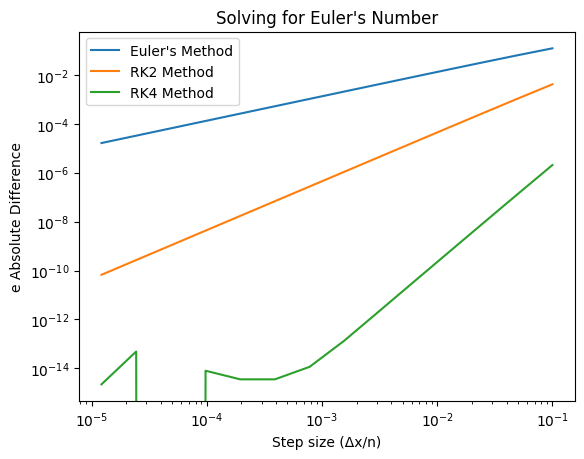

In [20]:
# Euler's Number Plot
plt.loglog(e_step_size, e_abs_diff[0], label="Euler's Method")
plt.loglog(e_step_size, e_abs_diff[1], label="RK2 Method")
plt.loglog(e_step_size, e_abs_diff[2], label="RK4 Method")

plt.ylabel("e Absolute Difference")
plt.xlabel("Step size (Δx/n)")
plt.title("Solving for Euler's Number")

plt.legend()
plt.show()

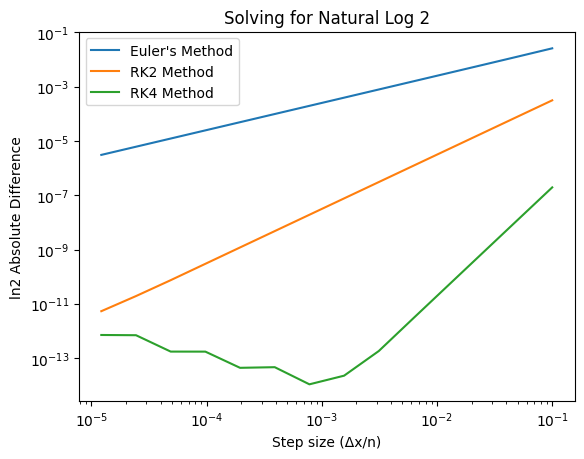

In [21]:
# ln(2) Plot
plt.loglog(ln2_step_size, ln2_abs_diff[0], label="Euler's Method")
plt.loglog(ln2_step_size, ln2_abs_diff[1], label="RK2 Method")
plt.loglog(ln2_step_size, ln2_abs_diff[2], label="RK4 Method")

plt.ylabel("ln2 Absolute Difference")
plt.xlabel("Step size (Δx/n)")
plt.title("Solving for Natural Log 2")

plt.legend()
plt.show()

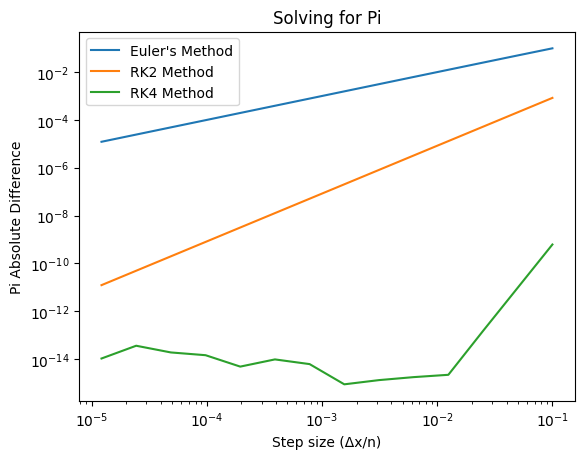

In [22]:
# Pi Plot
plt.loglog(pi_step_size, pi_abs_diff[0], label="Euler's Method")
plt.loglog(pi_step_size, pi_abs_diff[1], label="RK2 Method")
plt.loglog(pi_step_size, pi_abs_diff[2], label="RK4 Method")

plt.ylabel("Pi Absolute Difference")
plt.xlabel("Step size (Δx/n)")
plt.title("Solving for Pi")

plt.legend()
plt.show()

### 2C: Comparing the methods quantitatively (3 points)

Address the following:

1.   What is the dominant shape in these plots? ✅ What does this mean about the dependence on $h$, and what is this dependence expected to be for the given methods? ✅
2.   Make quantitative estimates of the slopes of the methods in all 3 cases. ✅ Where do these slopes align with the expected values? ✅ Where do they not? ✅
3.   What is going in with RK4 for $h \lesssim 10^{-3}$ (or $10^{-2}$ for $\pi$)? ✅ What sets the scale of this behavior? ✅



In [23]:
for constant in ["e", "ln2", "pi"]:
    for method in [0, 1, 2]:

        step_size = eval(constant + "_step_size")
        abs_diff = eval(constant + "_abs_diff" + str([method]))
        
        if method == 2:
            if constant == "e":
                step_size = eval(constant + "_step_size" + "[:7]")
                abs_diff = eval(constant + "_abs_diff" + str([method]) + "[:7]")

            if constant == "ln2":
                step_size = eval(constant + "_step_size" + "[:6]")
                abs_diff = eval(constant + "_abs_diff" + str([method]) + "[:6]")

            if constant == "pi":
                step_size = eval(constant + "_step_size" + "[:6]")
                abs_diff = eval(constant + "_abs_diff" + str([method]) + "[:6]")
        
        slope, _ = np.polyfit(np.log(step_size), np.log(abs_diff), 1)

        methods = ["euler", "rk2", "rk4"]

        print("slope for ", constant, " with ", methods[method], ": ", slope)

    print("\n")


slope for  e  with  euler :  0.9938291104878123
slope for  e  with  rk2 :  1.9947601693095105
slope for  e  with  rk4 :  3.981329505687597


slope for  ln2  with  euler :  1.0017266360087527
slope for  ln2  with  rk2 :  1.99284313513233
slope for  ln2  with  rk4 :  4.0021790372487285


slope for  pi  with  euler :  0.9988299661326545
slope for  pi  with  rk2 :  2.000004262455135
slope for  pi  with  rk4 :  3.9277489776385592




✍🏽
1. The dominant shape is an upwards sloping correlation, which means that as we reduce the step size (making smaller and smaller iterations in our computational methods), our absolute difference also decreases significantly. Effectively, as we decrease $h$, we get closer to our "true" value. This is to be expected because with smaller step sizes, the better we represent the exact continous function with discrete steps.
2. We see in the table below that the slopes generally align such that the Euler's method produces a slope of 1, the RK2 method produces a slope of 2, and the RK4 method produces a slope of 4. In order to achieve such results, I had to cut off the non-linear parts of the slopes for RK4, because the slopes in these lines are unclear below some threshold. To be specific, this threshold after which the RK4 method produces non-linear slopes is between 10e-2 and 10e-4. Hence we know the slopes align with expected values for most of Euler's Method and RK2, while not aligning for h < 10e-2 in the RK4 method. 

| Constant | Euler's Method | RK2 | RK4 |
| --- | --- | --- | --- |
| e | 0.9938 | 1.9947 | 3.9813 |
| ln2 | 1.0017 | 1.9928 | 4.0021 |
| pi | 0.9988 | 2.0000 | 3.9277 |

3. My guess is that because the RK4 method gets to the absolute difference ranges of 10e-14 or 10e-15, what we're seeing is that below 10e-2 in step size, when our RK4 method tries to calculate the 2nd derivative at this order, it often is multiplying the step size by the difference. This results in values on the magnitude of 10e-16 or 10e-17, the same threshold of truncation error in python. I believe that in RK4, this is a relevant constraint on the minimum bounds of accuracy we're able to achieve and hence the scale of the non-linear behavior is defined by python's truncation error constraints.

### 2D: Go nuts (optional)
Let's try to get even more interesting numbers. Find a differential equation such that extrapolation from $x = 0$ to $x = 1$ gives a value $y(1) = e^π$. Specifically, give the differential equation and initial condition $y(0)$ needed to get $e^π$. Of course you cannot explicitly have $e$ or $\pi$ in your differential equation! Check your work by solving with one of your methods above for a suitably small $h$.

your text here - skipping unfortunately 😔

In [24]:
# your code here - skipping unfortunately 😔

## Question 3: Integrals to $\infty$ (10 points)

In the problems we've encountered so far, we've used our numerical integration techniques over finite domains $x\in[a,b]$. What if we want to evaluate an integral whose domain is *infinite*? ✅ Is numerical integration even useful here? ✅

✍🏽 Not sure if this is a rhetorical question but: If we're trying to evaluate integral over infinite domain, we can still consider the limits as we approach a $\frac{1}{z}$ type function. Hence numerical integration can still be useful here. 

Let's look at one of the classics: the integral of a Gaussian over the real line. This is an integral that we can do analytically, of course, but calculating it numerically will give us some insight into how we'd deal with more complicated versions that aren't as easily solved on paper.

\begin{align*}
    I=\int_{-\infty}^{\infty} e^{-x^2}\, dx
\end{align*}

If we approach this integral head-on with trapezoids or Simpson's approximation, things won't go well &mdash; we'd be asking the computer to use an infinite number of intervals (or infinitely wide intervals, if we specify a finite number of them).

---

To make things numerically tractable, let's change variables so that the limits of the integral become finite. There are many different ways to choose a new variable $z$ such that $x$ approaches positive and negative infinity as $z$ approaches two different finite values. For this purpose, it's often helpful to use a denominator such as $(1-z)$ or $(1-z^2)$ so that $x$ diverges as $z$ approaches finite values like $1$ or $-1$. As an example, we'll use

\begin{align*}
    x \equiv \frac{z}{1-z^2}\quad\implies\quad dx=\frac{1+z^2}{(1-z^2)^2}\, dz\ ,
\end{align*}

so that $x\rightarrow\pm\infty$ corresponds to $z\rightarrow\pm1$. The original integral then becomes

\begin{align*}
    I = \int_{-1}^{1} \frac{1+z^2}{(1-z^2)^2}\,\exp\left[-\,\frac{z^2}{(1-z^2)^2}\right]\, dz\ .
\end{align*}
\
We've sacrificed some elegance in our expression for $I$, but on the plus side, numerical integration works best when it doesn't require infinite computational resources. We now have a problem that we can handle using the techniques we've learned for definite integrals.

### 3A: Implement the and plot transformed integral (2 points)

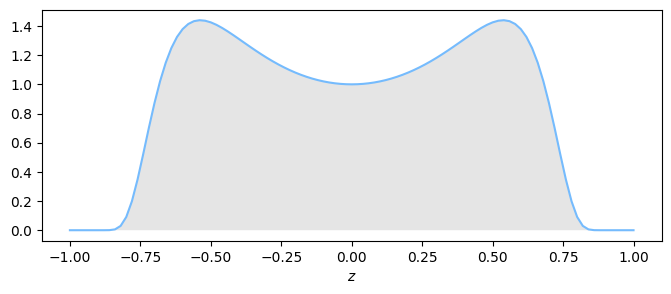

In [25]:
# Visualize the integral in its new form

def integrand(z):
    """
        Computes the function value of the integrand above.

        Inputs:
        z: integration variable

        Output:
        Integrand value at z
    """

    # your code goes here ✅
    z2 = z**2 # define z^2 for easier interpretation

    term1 = (1 + z2)/((1 - z2)**2)
    term2 = np.e**((-1 * z2)/((1 - z2)**2))

    return term1*term2


# Use a small epsilon to avoid divide-by-zero at lower/upper bounds
epsilon = 1e-6

# Set number of points to plot
n_points = 101

lower_bound = -1 + epsilon
upper_bound = 1 - epsilon

x_vals = np.linspace(lower_bound, upper_bound, n_points)
y_vals = integrand(x_vals)

# Plot integrand
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(x_vals, y_vals, color='xkcd:sky blue')
ax.fill_between(x_vals, y_vals, facecolor=(0,0,0,0.1), zorder=-1)
ax.set_xlabel('$z$')
plt.show()

### 3B: Solve the integral with the trapzoidal rule (2 points)

In [26]:
# Compute the integral using np.trapz and the plotted x,y values
integral = np.trapz(x_vals, -y_vals) # ✅
true_val = np.sqrt(np.pi)

print(f'Trapezoidal approximation, {n_points - 1} intervals:\n{integral}\n')
print(f'True value (square root of pi):\n{true_val}\n')

# Calculate error relative to true value I = sqrt(pi)
print(f'Relative error: {np.abs(integral - true_val) / true_val:.3e}')

Trapezoidal approximation, 100 intervals:
1.7724538508774184

True value (square root of pi):
1.7724538509055159

Relative error: 1.585e-11


---
Using the trapezoidal approximation on our transformed integral, we get a very accurate estimate of the true value, which is

\begin{align*}
    \int_{-\infty}^{\infty}e^{-x^2}\,dx=\sqrt{\pi}\ .
\end{align*}

Because this integral was symmetric, we could have also just calculated the half from zero to infinity, then doubled that result. In that case, where the integral starts at zero, can you think of an even simpler change of variable that would make the upper limit finite, instead of positive infinity? This might come in handy below! ✅

---

✍🏽 If we're only from $0$ to $\infty$, then we can consider the change of variable $ x = \frac{z}{1-z} $. Here, we maintain that the lower bound is $0$ and the upper bound becomes $ \infty = \frac{z}{1-z} $ so $ z \rightarrow 1$.

Try it out:
Apply the strategy we saw above to the following integral, which is used in deriving the Stefan-Boltzmann constant:

\begin{align*}
    I=\int_0^{\infty}\frac{x^3}{e^x-1}\, dx
\end{align*}
    
1) Find a new change of variable (**not** the one used in the example above!) which transforms this integral into one with finite bounds. Write your new integrand as a Python function and plot it over the relevant domain (as in the example above). ✅
2) Choose one of the numerical integration techniques we've learned and use it to calculate the value of this integral (feel free to use `numpy` or `scipy` functions for this). Calculate the error in your result relative to the true value, which is $I=\frac{\pi^4}{15}$. ✅

### 3C: Find an appropriate change of variable (2 points)

Write down a new change of variable that transform the above integral to finite bounds: 

✍🏽 $ x = \frac{1}{1-z^2} $. This makes our bounds $0$ and $1$, because as $z \rightarrow \pm 1, x \rightarrow \infty$.

### 3D: Implement and plot transformed integral (2 points)

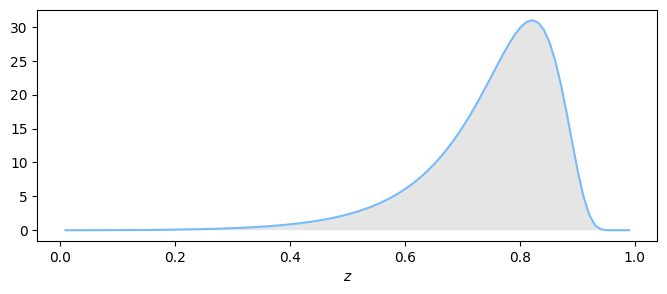

In [27]:
def new_integrand(z):
    """
        Computes the function value of your transformed integrand.

        Inputs:
        z: integration variable

        Output:
        Integrand value at z

        Substitution: 1/(1 - z^2), which leads to new bounds of 0 and 1
    """

    # your code here
    return (z**3 / (1 - z)**5) / (np.e**( z/(1 - z)) - 1)


# Set number of points to plot
n_points = 100

# If needed, use epsilon to avoid divide-by-zero at lower/upper bounds
epsilon = 1e-2

lower_bound = 0 + epsilon
upper_bound = 1 - epsilon

x_vals = np.linspace(lower_bound , upper_bound, n_points)
y_vals = new_integrand(x_vals)

# Plot your new integrand
# your code here
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(x_vals, y_vals, color='xkcd:sky blue')
ax.fill_between(x_vals, y_vals, facecolor=(0,0,0,0.1), zorder=-1)
ax.set_xlabel('$z$')
plt.show()

### 3E: Solving the transformed integral (2 points)

Now compute the integral numerically using a method of your choice, and compare with the analytic solution

In [28]:
# Compute the integral using np.trapz and the plotted x,y values
integral = np.trapz(x_vals, -y_vals) # ✅
true_val = (np.pi**4)/15

print(f'Trapezoidal approximation, {n_points - 1} intervals:\n{integral}\n')
print(f'True value (pi^4 over 15):\n{true_val}\n')

# Calculate error relative to true value I = pi^4 over 15
print(f'Relative error: {np.abs(integral - true_val) / true_val:.3e}')

Trapezoidal approximation, 99 intervals:
6.4939399239997515

True value (pi^4 over 15):
6.493939402266828

Relative error: 8.034e-08


We can tell that this matches the analytic solution ✅.

## Question 4: Root-Finding an Instability (10 points)

A particular system's state variables $\vec{x}$ have an equilibrium point $\vec{x}_0$, and for small deviations about this equilibrium point $\vec{v} = \vec{x} - \vec{x}_0$, we can linearize the time evolution so that the deviations evolve as:
$$ \frac{d}{dt} \vec{v} = \mathbf{M} \vec{v},$$
for the matrix $\mathbf{M}$ defined in the code below.

The eigenvectors $\vec{y}_n$ of $\mathbf{M}$ represent modes of oscillation around this equilibrium point and evolve as $e^{\nu_n t}$, where $\nu_n$ are the corresponding eigenvalues. We write $\nu_n = \gamma_n + i \omega_n$ for real $\gamma_n, \omega_n$, and this gives meaning to the eigenvalues: real parts $\gamma_n$ correspond to exponential growth or decay of the modes, while imaginary parts $\omega_n$ correspond to (angular) frequencies of oscillation of the modes. Importantly, **if any mode's eigenvalue $\gamma_n$ has a positive real part, then the equilibrium point is unstable**. So to determine the stability of the equilibrium: first diagonalize, then take the largest real part of the eigenvalues, then check if it is positive or not.

We are interested in when off-diagonal coupling elements in $\mathbf{M}$ get sufficiently large to drive the equilbrium from stable to unstable. This root-finding problem for the coupling elements is not amenable to the Newton-Raphson method because the process of diagonalizing and taking the largest real part does not have a derivative. (Or if it does, it is quite complicated to evaluate--if you are up for a challenge, consider what this derivative would be.) But for systems with many degrees of freedom, we want an efficient method. This problem will investigate two bracketing methods: bisection and the builtin Ridder's method.

### 4A: Bisection with some fixins (2 points)

Write a root-finding function that implements the bisection method. Ensure the following:


*   The function takes a tolerance argument; as soon as the bracket is smaller than this tolerance, it should return the midpoint of the bracket. ✅
*   **The function keeps track of the number of steps it takes, and returns this as well.** This will be used later to track efficiency. "Step" means the number of bisections, which should be within 2 of the minimum number of function evaluations in the most efficient bisection implementation. ✅
*   The function uses the `*args` syntax to allow the objective function (the one whose root we want to find) to take more than one argument. Refer to the Numerical Basics: Python Function Tutorial notebook. ✅



In [29]:
# your code here ✅
def root_finding(tolerance, x_guess_min, x_guess_max, func, *func_vars):

    # initialize guesses that bracket solution
    x_min, x_max = x_guess_min, x_guess_max

    # initialize step counter and done metric.
    not_done, steps = True, 0

    while not_done:

        steps += 1
        x_prime = 0.5*(x_min + x_max) # update prime to average

        if np.sign(func(x_min, *func_vars)) == np.sign(func(x_prime, *func_vars)): # increase range if signs are same
            x_min = x_prime 
        else:
            x_max = x_prime

        if not np.abs(x_max - x_min) > tolerance:  # check target accuracy
            not_done = False

    final_estimate = 0.5*(x_min + x_max)

    return final_estimate, steps

### 4B: Root-finding the given function (3 points)

The objective function whose root we want to find is provided in the code below. We are mostly treating it as a black box, but if you are interested, it is inspired by the Dicke model: see <a target="_blank" rel="noopener noreferrer" href="https://arxiv.org/abs/1805.09828">Kirton et al 2018</a>, equation 18.

In [30]:
# Objective function for root-finding. It returns the largest real part among
# the eigenvalues.
def f(g, omega_1):
    g_1, g_2 = g, g
    omega_2 = 1.
    gamma_1, gamma_2 = 0.01, 0.05
    M = -1j * np.array([[omega_1 - 1j*gamma_1, 0, g_1/2, g_2/2],
                        [0, -omega_1 - 1j*gamma_1, -g_2/2, -g_1/2],
                        [g_1/2, g_2/2, omega_2 - 1j*gamma_2, 0],
                        [-g_1/2, -g_2/2, 0, -omega_2 - 1j*gamma_2]])
    evals = np.linalg.eigvals(M)
    return np.max(np.real(evals))

The function takes two inputs: `g`, representing the off-diagonal matrix element coupling two of the system's modes; and `omega_1`, represending the uncoupled (angular) frequency of mode 1. The uncoupled (angular) frequency of mode 2 is fixed at 1, and the uncoupled decays of the two modes `gamma_1` and `gamma_2` are fixed at 0.01 and 0.05, respectively. The general model allows for two couplings `g_1` and `g_2` but for simplicity we are setting them equal.

We need some guidance to set our bracket properly. Plot the objective function for `omega_1` set to 0.3 as `g` ranges from 0 to 1. ✅ Make sure to label your axes. ✅

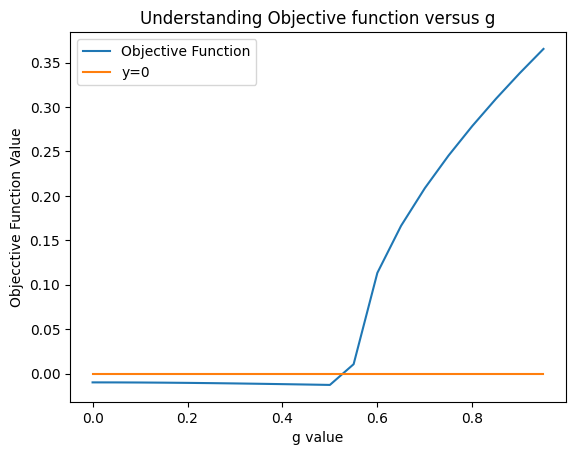

In [31]:
# your code here
g_vals = np.arange(0, 1, 0.05)
plt.plot(g_vals, [f(g, 0.3) for g in g_vals], label="Objective Function")
plt.plot(g_vals, [0 for _ in g_vals], label="y=0")

plt.xlabel("g value")
plt.ylabel("Objecctive Function Value")
plt.title("Understanding Objective function versus g")

plt.legend()
plt.show()

Looking at the form of the function, what would happen if we tried to use the secant method with starting guesses of $0.7$ and $0.6$? ✅

✍🏽 Looking at our function, if we tried to use starting guesses for g of min 0.6 and max 0.7, we would fail because our root solution isn't in that range. Instead, we would want to use starting guesses of a range between 0.4 and 0.6.

The plot above should indicate that the root is between 0 and 1. Run your root-finder, keeping track of both the roots and the number of steps, for the range of `omega_1` values below and with a starting bracket of $[0, 1]$. Choose an appropriate tolerance.

Plot the roots versus `omega_1`. Make sure to label your axes. ✅

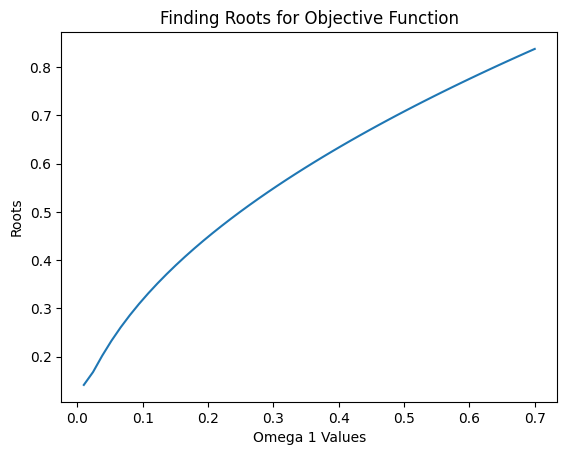

In [32]:
omega_1_arr = np.linspace(0.01, 0.7, num=50)
# your code here

# initialize results lists
roots = []
step_hist = []

for omega in omega_1_arr: # consider every omega1 in list

    solution, steps = root_finding(1e-6, 0, 1, f, omega)

    # append solutions
    roots.append(solution)
    step_hist.append(steps)

plt.plot(omega_1_arr, roots)

plt.xlabel("Omega 1 Values")
plt.ylabel("Roots")
plt.title("Finding Roots for Objective Function")

plt.show()

### 4C: Checking the results so far (2 points)

The uncoupled decays are relatively small compared to the uncoupled frequencies. In the limit where the uncoupled decays go to zero, a well-known result is $g_c^2 = \omega_1 \omega_2$: the critical coupling at which the equilibrium goes unstable is given by the geometric mean of the two uncoupled frequencies. Recall that we set $\omega_2 = 1$ in our system.

Add a plot of this expression for $g_c$ on top of your roots found from before, using a dashed or a dotted line so that the two can both be seen. ✅ Where does it match, and where does it differ? Why might that be the case? ✅

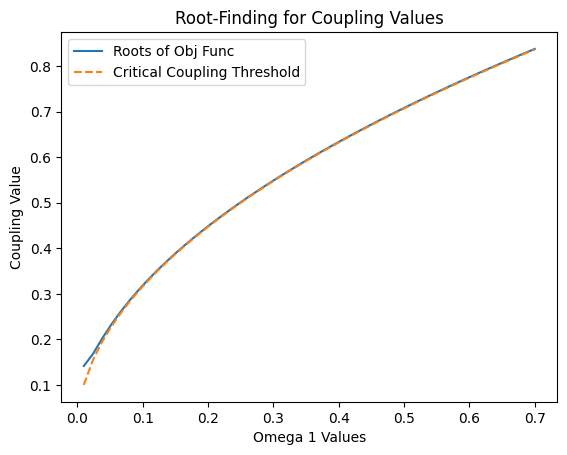

In [33]:
# your code here
plt.plot(omega_1_arr, roots, label="Roots of Obj Func")
plt.plot(omega_1_arr, np.sqrt(omega_1_arr), '--', label="Critical Coupling Threshold")

plt.xlabel("Omega 1 Values")
plt.ylabel("Coupling Value")
plt.title("Root-Finding for Coupling Values")

plt.legend()
plt.show()

✍🏽 It matches for most values of omega 1, except when omega 1 is close to zero. I imagine this might be because at omega 1 close to zero, our estimator keeps its lower bound at 0 and simply the upper bound gets halved every iteration. As a result, the discovered root is higher than what it would be if we continued to iterate for much longer. 

Print (do not plot) the list/array that you used to hold the number of steps taken. ✅ Is it what you expect it to be? ✅ Why is it the way it is? ✅

In [34]:
print(step_hist)

[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]


✍🏽 No, I would've expected that for our root finding process, that some roots might be easier to find and hence would take a varying amount of steps. Alternatively, we can assume that because we're trying to get some tolerance and the function halves everytime, there might a point (2^20) that we first cross the specified tolerance threshold. 

### 4D: Introducing `scipy.optimize.root_scalar` and convergence rates (3 points)

With both the Newton-Raphson and secant methods unavailable, we are forced to use bracketing methods. But bisection is not the only bracketing method out there. As in the last problem set, we introduce a library function: this time it is `scipy.optimize.root_scalar`. Refer to <a target="_blank" rel="noopener noreferrer" href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root_scalar.html">the documentation</a>.

This function is within the `scipy.optimize` package, and you may want to refer to the <a target="_blank" rel="noopener noreferrer" href="https://docs.scipy.org/doc/scipy/reference/optimize.html">optimize documentation page</a> as well. 

This page indicates that the "ridder" solver is a bracketing method that is guaranteed to converge, and it has a "Rate" that is greater than bisection. So let us check it out!

Run both your bisection and `scipy.optimize.root_scalar` for `omega_1` fixed at $0.3$ and for tolerances $10^{-2}, 10^{-3}, 10^{-4}, \ldots, 10^{-13}$.

When calling `root_scalar`:


*   Use the `args` keyword argument of `root_scalar` to properly pass in `omega_1`. ✅
*   Set `method='ridder'`. ✅
*   Use the same bracket $[0, 1]$ as you use for bisection. ✅
*   Set `xtol` to the desired tolerance. ✅
*   Do not set any of the other keyword arguments. ✅

`root_scalar` will return a `scipy.optimize.RootResults` object. Refer to <a target="_blank" rel="noopener noreferrer" href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.RootResults.html">the documentation for RootResults</a>.

For now, keep all the `RootResults` objects in a list. ✅

In [35]:
from scipy.optimize import root_scalar

# your code here
tolerances = [10**(-tol) for tol in range(2, 14)]

# initialize empty lists to store results
bisection_results, ridder_results = [], []
bisection_steps = []

for tolerance in tolerances: 
    # bisection method
    sol_bisection, steps = root_finding(tolerance, 0, 1, f, 0.3)
    bisection_results.append(sol_bisection) # append results
    bisection_steps.append(steps) # append steps

    # ridder method
    sol_ridder = root_scalar(f, args=(0.3,), method='ridder', bracket=[0, 1], xtol=tolerance)
    ridder_results.append(sol_ridder) # append results

Now, make a scatter plot that contains both: the number of steps taken by bisection, and the number of function calls performed by `root_scalar` (refer to the `RootResults` documentation above on how to obtain this) versus $1 / \mathrm{tol}$ ✅. Use a log scale for the x-axis ✅; note that it should range from $10^2$ to $10^{13}$. Make sure to label the series and the axes ✅.

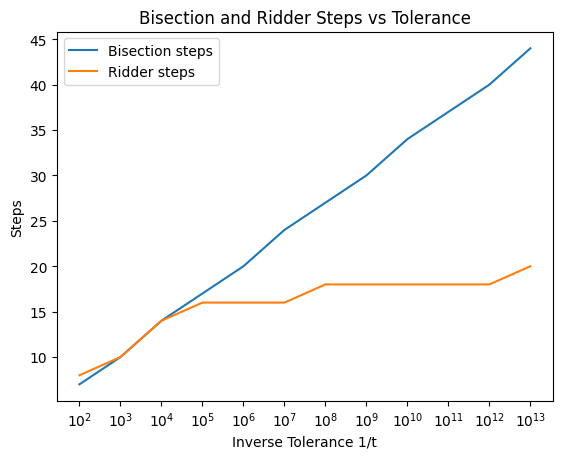

In [36]:
# your code here
ridder_steps = [ridder_results[i]["function_calls"] for i in range(len(ridder_results))]
inv_tolerances = [1/i for i in tolerances]

plt.plot(inv_tolerances, bisection_steps, label="Bisection steps")
plt.plot(inv_tolerances, ridder_steps, label="Ridder steps")

plt.xlabel('Inverse Tolerance 1/t')
plt.ylabel('Steps')
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.xticks(inv_tolerances)
plt.title('Bisection and Ridder Steps vs Tolerance')
plt.legend()
plt.show()


What does this plot indicate about the number of function calls needed for bisection versus Ridder's method? ✅ In particular, how do the numbers of function calls for the two methods grow with the number of decimal places of desired accuracy? ✅

✍🏽 As we increase the desired tolerance, the ridder method evenutally requires less function calls than the bisection method. Specifically, at approximately a tolerance of 10e-4, we begin to really see the ridder method almost flatten, not requiring significanlty more steps afterwards. Alternatively, we see that the bisection method has an almost log relationship between the desired tolerance and the number of steps. This is more than the ridder's method. 

P.S. The ridder mechanism almost seems to be a log function, hence maybe is log(log) steps for each tolerance value. 

### Remarks


*   While this $4 \times 4$ system is simple and very fast to diagonalize, many real-life dynamical systems have large matrices $\mathbf{M}$, so one might care a great deal about how many function calls are made--each call could take minutes to hours!
*   4D is an introduction to the idea of a convergence rate (note: the terminology of convergence "rate" and "order" is not standardized): a method attempting to find a particular value is said to converge "linearly" if the number of decimal places of accuracy grows linearly (rate 1) in the number of steps, and quadratically (rate 2) if the number of places grows quadratically, etc.. Many methods have rates that are either $1$, $\varphi = \frac{1 + \sqrt{5}}{2} \approx 1.6$, or $2$.

